In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

This notebook processes the data for seasonal batting and pitching averages to be used in the pitch outcome modelling. The numbers of dimensions is reduced using Principal component analysis. Batter and pitcher data is processed seperately. The outputs of the notebook are used in the modelling notebook. 

### Seasonal batting data 

alongside the pitch-by-pitch data, seasonal batting data is downloaded directly via Baseballsavant.com via thier custom leaderboard (https://baseballsavant.mlb.com/leaderboard/statcast) 

This data is used for Principal component analysis to reduce the numbers of variables into indentifiable hitter dimensions. 



1. 'last_name, first_name' - last and first name of the pitcher
2. 'player_id' - player id as defined by MLB
3. 'year' - baseball season
4. 'pa' - number of plate appearances 
5. 'k_percent' - stike out percentage
6. 'bb_percent' - walk percentange
7. 'xba' - expected batting average
8. 'xslg' - expected slugging
9. 'xwoba' - expected Weighted On-base Average
10. 'xwobacon' - expected weighted On-Base Average on Contact

12. 'hard_hit_percent' - the percentage of batted balls with an exit velocity of 95 mph or more.
13. 'sweet_spot_percent' - The percentange of batted-balls with a launch angle between eight and 32 degrees.
14. 'avg_hyper_speed' - average exit velocity
15. 'z_swing_percent' - percentage of in-zone swings
16. 'z_swing_miss_percent' - percentage of in-zone swings and misses
17. 'iz_contact_percent' - percentage of in-zone contact
18. 'oz_swing_percent' - percentage of out-of-the-zone swings
19. 'oz_swing_miss_percent' - percentage of out-of-the-zone swings and misses
20. 'oz_contact_percent' - percentage of out-of-the-zone contact
21.  The following variables are derived by statcast as a combination of launch angle and exit velocity. For more information please see MLB's description: https://www.mlb.com/glossary/statcast/sweet-spot

- 'barrel_batted_rate' -the percentage of batted balls with the perfect combination of exit velocity and launch angle

- 'poorlyweak_percent' - percentage of balls hit with weak contact

- 'poorlyunder_percent' -percentage of balls hit under

- 'poorlytopped_percent' -percentage of balls topped

- 'solidcontact_percent' - percentage of balls hit with solid contact

- 'flareburner_percent', - percentage of flare/burners hit


21. 'xhr' - expected home runs (this was downloaded separaterly and merged together)

## merging and cleaning 

Firstly home run data needs to be merged into the rest of the stats as this was not possible to download together. No other cleaning is necessary as the data file already include pitchers who have faced at least 50 batters

In [3]:
df_sc = pd.read_csv("statcast_pitchv2.csv")  #
hr = pd.read_csv("homeruns_pitch.csv") #home runs data also from statcast but needed to download separately and merge

In [5]:
#merging home runs into main dataset
df_sc = df_sc.rename(columns={"last_name, first_name": "Name"})  #matching name variables to merge together 
hr = hr.rename(columns={"player": "Name"})

hr = hr[["Name","team_abbrev", "xhr"]]


In [6]:
df_sc = pd.merge(df_sc, hr, how='left', on=['Name'])

In [7]:
df_sc.loc[df_sc.xhr.isna(), 'xhr'] = 0 #for players that had no homeruns this will appear as NA therefore converting to 0 

In [8]:
#creating xhr rate per at bats variable 
df_sc["xhr_rate"] = df_sc.xhr / df_sc.ab

In [9]:
df_sc

,Name,player_id,year,ab,k_percent,bb_percent,xba,xslg,xwoba,xwobacon,...,poorlyweak_percent,hard_hit_percent,avg_hyper_speed,z_swing_percent,z_swing_miss_percent,oz_swing_percent,oz_swing_miss_percent,team_abbrev,xhr,xhr_rate
0,"Taillon, Jameson",592791,2024,633,18.5,4.9,0.256,0.419,0.311,0.361,...,4.1,38.8,94.067910,65.6,12.1,27.8,39.9,CHC,20.3,0.032070
1,"Ashcraft, Graham",668933,2024,316,16.3,7.7,0.278,0.438,0.347,0.379,...,1.9,42.7,94.586504,72.3,13.2,26.2,46.6,CIN,8.6,0.027215
2,"Muñoz, Roddery",682610,2024,327,18.5,11.1,0.279,0.542,0.390,0.440,...,1.9,45.0,94.738416,67.4,15.4,25.8,43.0,MIA,25.3,0.077370
3,"Law, Derek",571882,2024,333,20.8,6.6,0.258,0.362,0.298,0.347,...,3.4,35.2,93.340481,67.8,16.0,34.0,50.8,WSH,4.9,0.014715
4,"López, Pablo",641154,2024,715,25.6,5.3,0.239,0.389,0.297,0.373,...,5.0,37.5,93.587929,70.7,19.2,33.0,43.7,MIN,26.4,0.036923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,"Povich, Cade",700249,2024,313,19.6,9.7,0.232,0.402,0.313,0.346,...,4.9,36.6,93.762289,67.1,16.5,26.1,38.1,BAL,11.8,0.037700
628,"Winckowski, Josh",670174,2024,298,17.9,7.7,0.262,0.411,0.322,0.361,...,6.5,43.1,94.343318,66.3,14.4,27.5,38.3,BOS,10.6,0.035570
629,"Cortes Jr., Nestor",641482,2024,661,22.8,5.5,0.236,0.396,0.295,0.356,...,4.2,43.6,94.470879,72.9,20.1,27.4,35.5,NaN,0.0,0.000000
630,"Liberatore, Matthew",669461,2024,323,21.2,7.8,0.251,0.415,0.316,0.372,...,5.6,38.6,94.390365,72.5,18.0,27.9,47.4,STL,11.3,0.034985


In [10]:
df_sc.columns

Index(['Name', 'player_id', 'year', 'ab', 'k_percent', 'bb_percent', 'xba',
       'xslg', 'xwoba', 'xwobacon', 'sweet_spot_percent', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'avg_hyper_speed', 'z_swing_percent', 'z_swing_miss_percent',
       'oz_swing_percent', 'oz_swing_miss_percent', 'team_abbrev', 'xhr',
       'xhr_rate'],
      dtype='object')

### Principal component analysis (PCA)

Many of the metrics used in baseball are all highly correlated. A pitcher who give up a lot of home runs (xhr_rate) is typically going to have a high slugging against rate (xslg). We can observe this by conducting pairwise correlations of all the variables (plots have been split out by type of metrics: power, plate discipline and contact quality)



In [11]:
#select variables for PCA (dropping name id etc.)
data = df_sc[['k_percent', 'bb_percent', 'xba',
       'xslg', 'xwoba', 'xwobacon', 'sweet_spot_percent', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'avg_hyper_speed', 'z_swing_percent', 'z_swing_miss_percent',
       'oz_swing_percent', 'oz_swing_miss_percent', 'xhr_rate']]

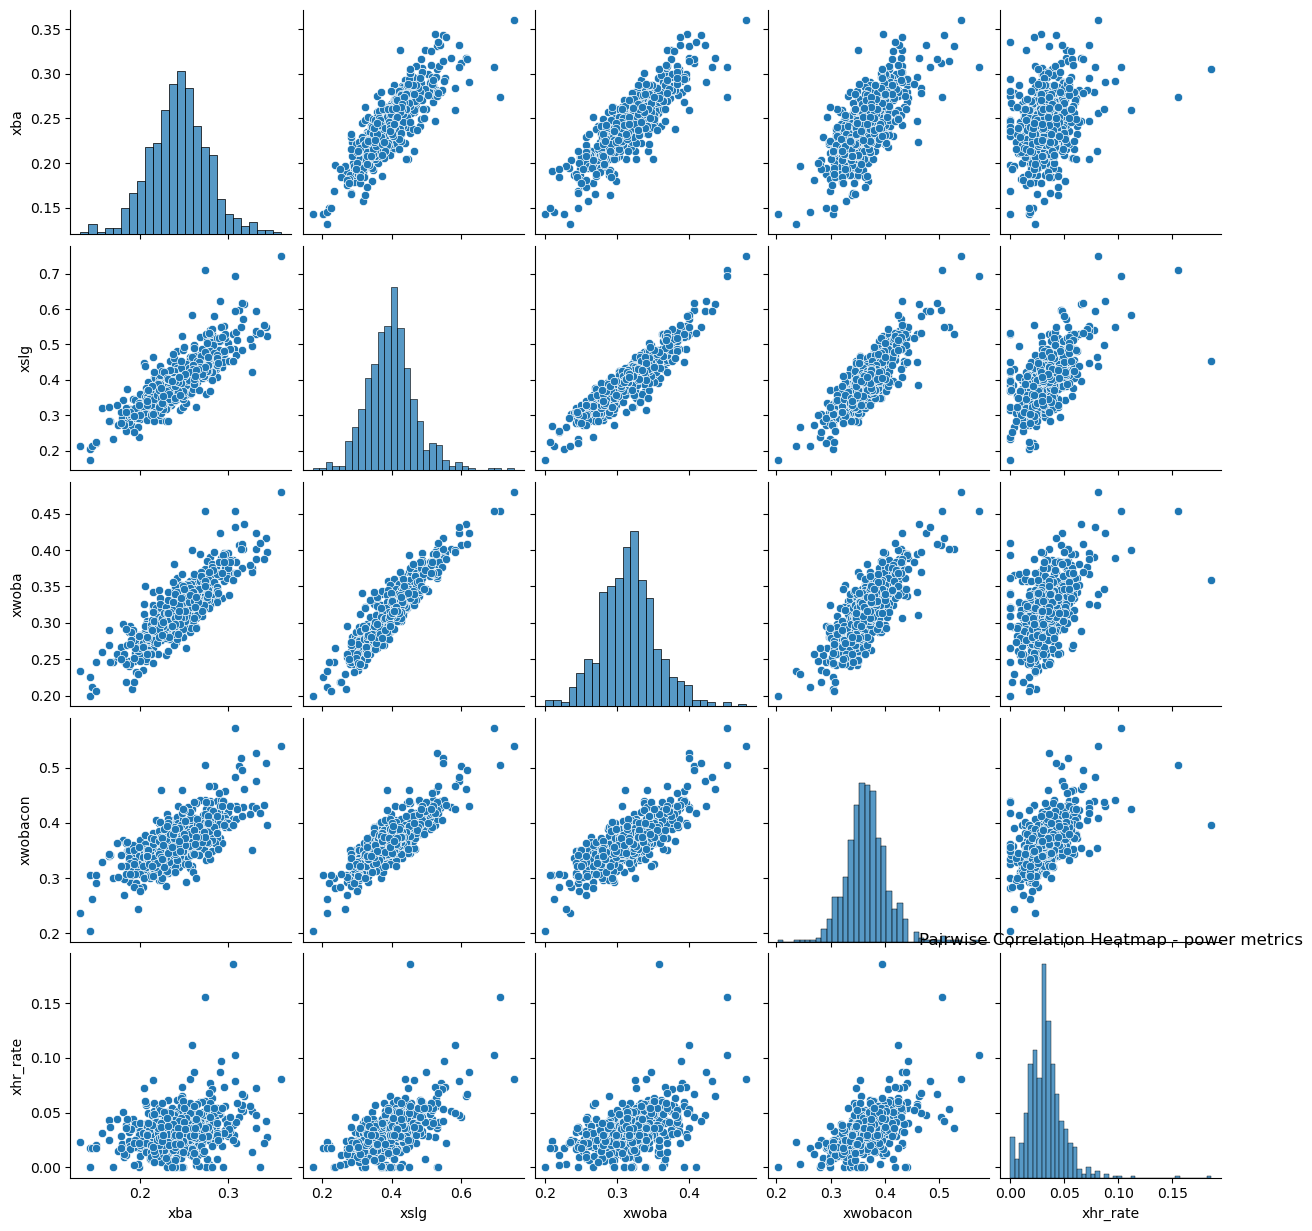

In [12]:
import warnings

# Suppress warnings only for this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.pairplot(data[[ 'xba','xslg', 'xwoba', 'xwobacon',  'xhr_rate']])
    plt.title("Pairwise Correlation Heatmap - power metrics")
    plt.show()

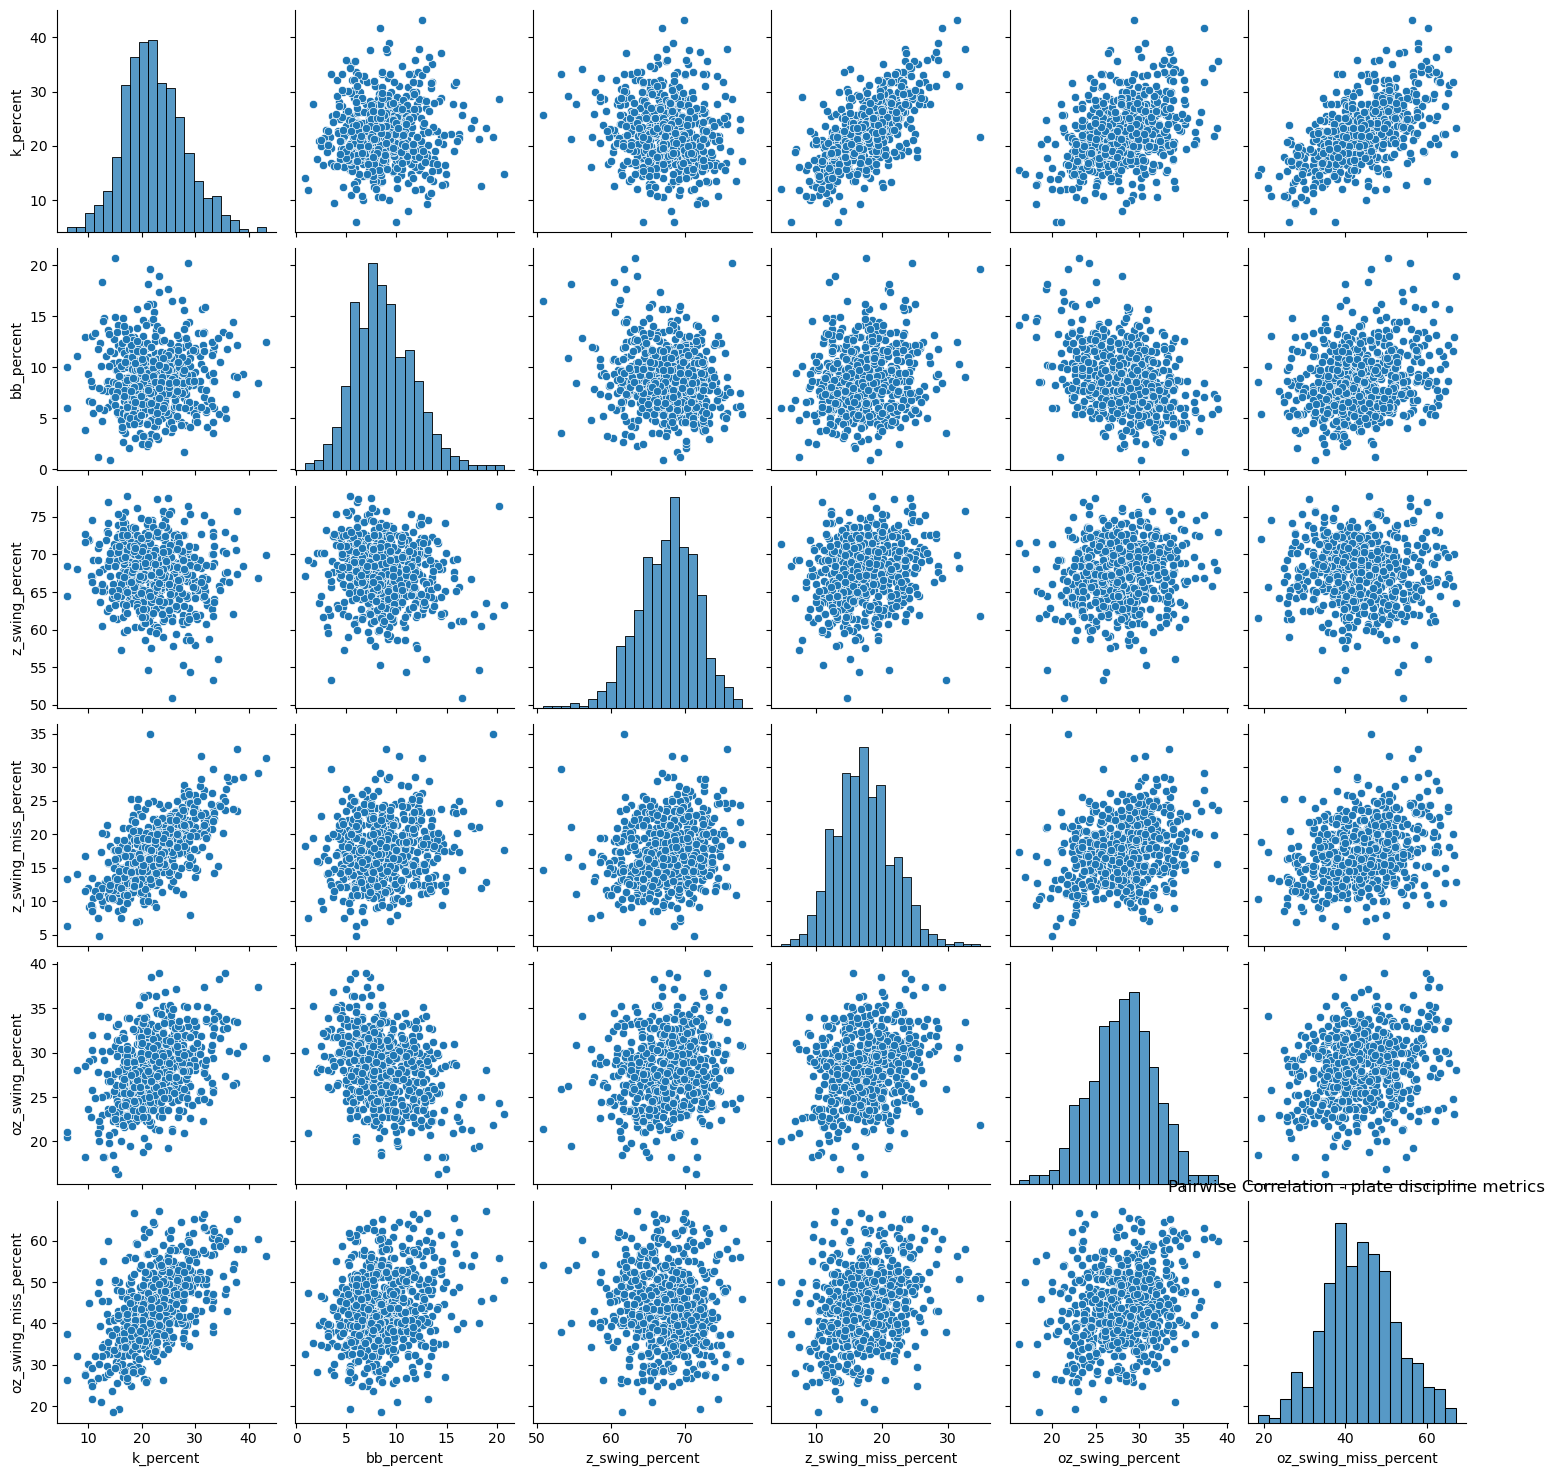

In [13]:
import warnings

# Suppress warnings only for this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.pairplot(data[['k_percent', 'bb_percent', 'z_swing_percent', 'z_swing_miss_percent',
       'oz_swing_percent', 'oz_swing_miss_percent']])
    plt.title("Pairwise Correlation - plate discipline metrics")
    plt.show()

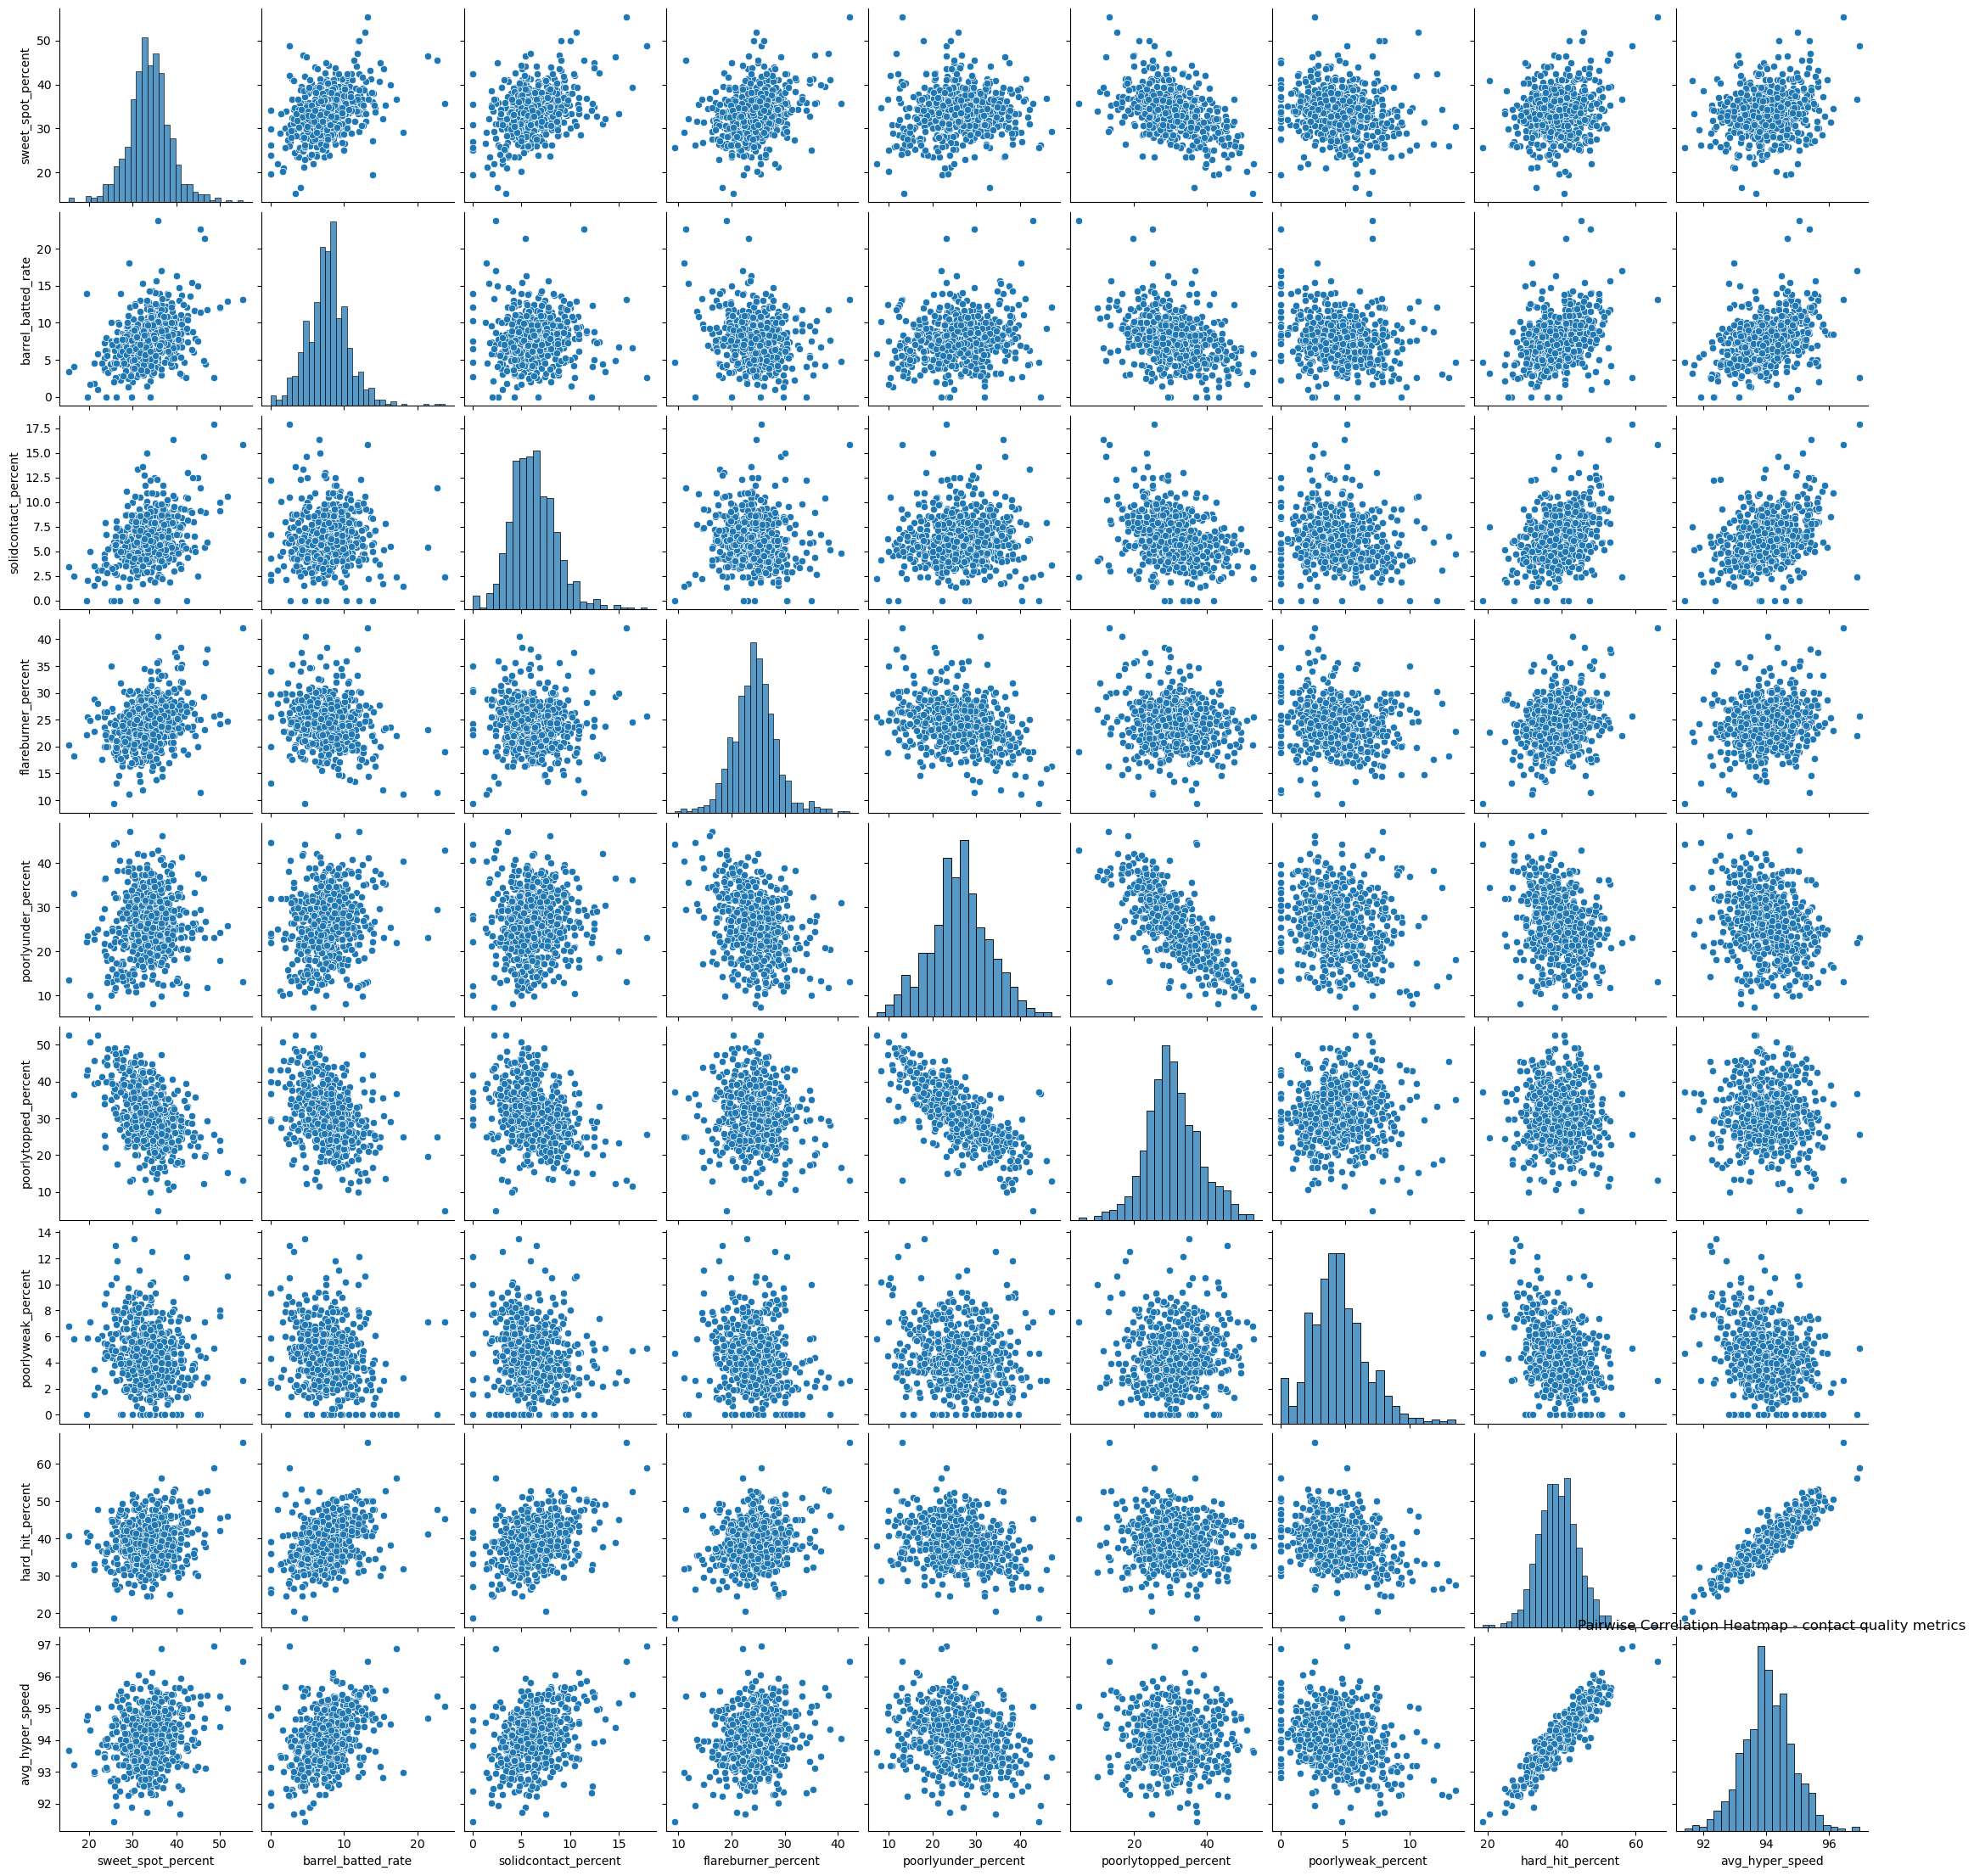

In [14]:
import warnings

# Suppress warnings only for this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.pairplot(data[['sweet_spot_percent', 'barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
           'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
           'avg_hyper_speed']])
    plt.title("Pairwise Correlation Heatmap - contact quality metrics")
    plt.show()


As we can see from the plots, there is a lot of correlation in the data. Whilst some models are able to handle this, it can be beneficial to reduce the number of dimensions using principal component analysis (PCA). 

PCA is a dimension reduction technique which is used to reduce a high number of correlated variables into a smaller set of uncorrelated variables (principal components (PCs)). PCA preserves the most important patterns or relationships between those variables. The principal components then represent underlying dimensions present in the data.

PCA is an unsupervised technique and the number of PCs need to be manually set. To determine this we can plot the PCs against the cumulative variance of the data. The first principal component captures the most variance, and susequent PCs capture progressively less. There are a number of methods used to choose the number of PCs including the elbow method (the point at which the plotted variance begins to tail off), or aprior decisions to take PCs that contribute a certain proportion of variance. 

Prior to conducting PCA, the data is scaled to ensure that all variables are comparable to one another

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [16]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
#data_test_scaled = scaler.transform(data_test)


Component 1 
Fraction of total variance explained by this variable: 0.3251795707543132 
 Total fraction of variance explained by the first 1 variable(s): 0.3251795707543132

Component 2 
Fraction of total variance explained by this variable: 0.13820505312055217 
 Total fraction of variance explained by the first 2 variable(s): 0.46338462387486534

Component 3 
Fraction of total variance explained by this variable: 0.09527007172496443 
 Total fraction of variance explained by the first 3 variable(s): 0.5586546955998297

Component 4 
Fraction of total variance explained by this variable: 0.08171465258881852 
 Total fraction of variance explained by the first 4 variable(s): 0.6403693481886482

Component 5 
Fraction of total variance explained by this variable: 0.06710756123088486 
 Total fraction of variance explained by the first 5 variable(s): 0.7074769094195331

Component 6 
Fraction of total variance explained by this variable: 0.06353244584523045 
 Total fraction of variance explain

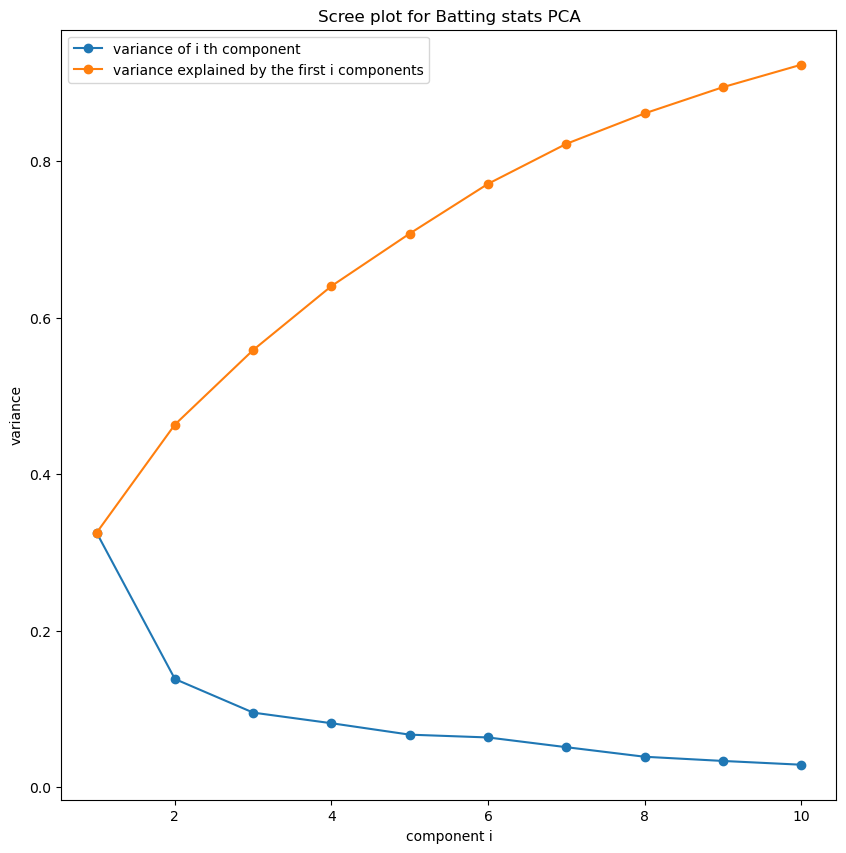

In [17]:
pca = PCA(10).fit(data_scaled)
var = pca.explained_variance_ratio_
var_explained = np.zeros(10)
for i in range(10):
    var_explained[i] = sum(var[:i+1])

for i in range(10):
    print("\nComponent", i+1 , "\nFraction of total variance explained by this variable:", var[i],
            "\n Total fraction of variance explained by the first %s variable(s):" % (i +1), var_explained[i] )

plt.figure(figsize = (10,10))
plt.plot(range(1, len(var_explained)+1), var, label = "variance of i th component", marker = "o")
plt.plot(range(1, len(var_explained)+1), var_explained, label = "variance explained by the first i components", marker = "o")
plt.xlabel("component i")
plt.ylabel("variance")
plt.title("Scree plot for Batting stats PCA")
plt.legend()
plt.show()


Based on the plot and the variance explain, I have opted for 4 PCs for pitchers as the variance begins to tail off after this. This explains less variance (64%) than batters (80%) (see Batter PCA notebook) however since we're using pitch-by-pitch which includes much more data about pitching, we can afford to lose variance at this stage.

In [18]:

pca = PCA(4).fit(data_scaled)
# Create a DataFrame of the PCA components
loadings = pd.DataFrame(pca.components_.T, index=data.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
#loadings.to_clipboard(index=True)

We can the evaluate the PCs using a number of approaches. A heat map can show generally how the variables load on to each PC. (each PCs is sorted iteratively to make it easier to determine which variables load onto each component)

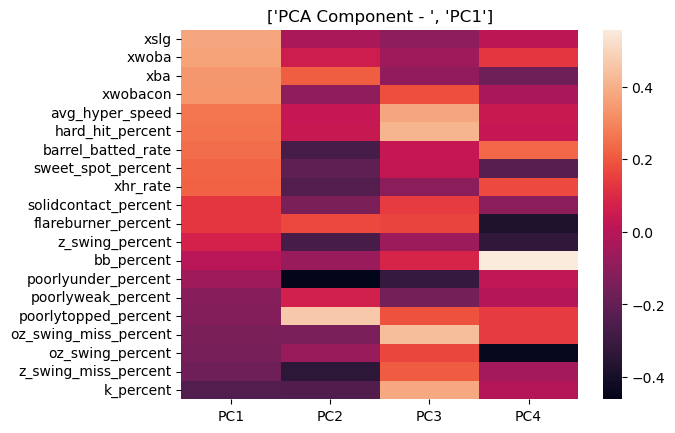

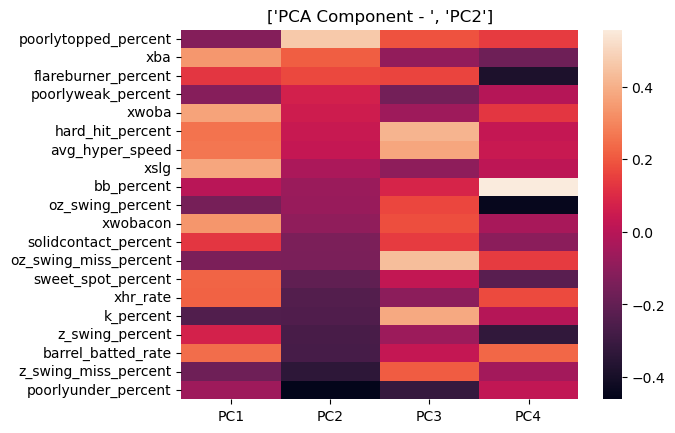

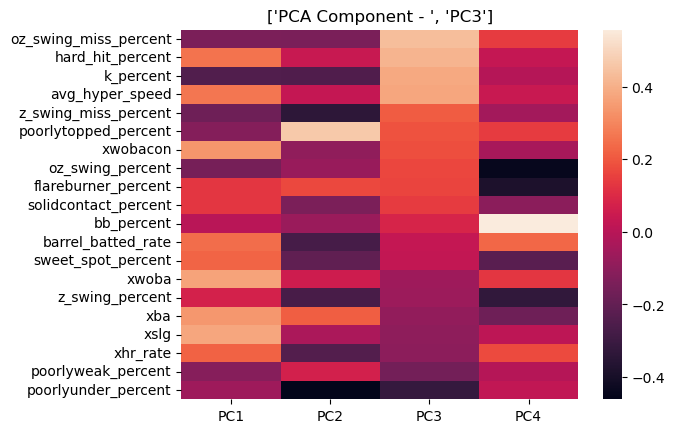

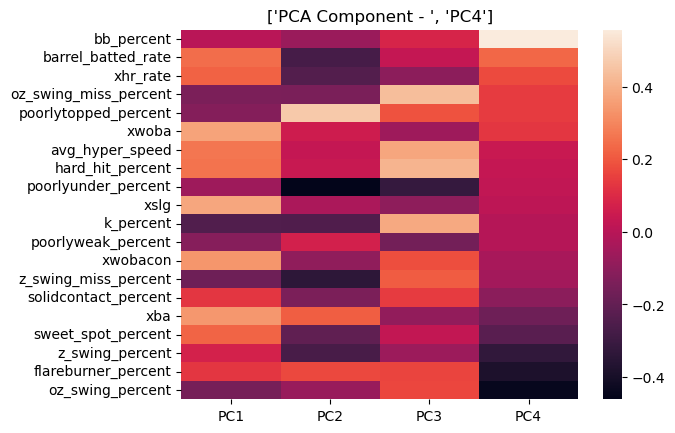

In [19]:
for i in loadings.columns:
    x = loadings.sort_values(by = i, ascending = False)
    sns.heatmap(x)
    plt.title(['PCA Component - ',i])
    plt.show()

In comparison to the batter PCA, there are similar components for pitcher but their interpretation varies slightly in the context of pitching. 

**PC1 - 'Contact quality and frequency'**:

The metrics that load onto this PC are those that measure the extent to which the hitter hits for power and makes good contact with the bat . Conversely the metrics that load negatively on to this PC are poor/weak hits. 

**PC2 - 'launch angle'**:

The main that load on to this PC are largely whether the ball is topped or hit under the bat (poorlyunder_percent) (negative loading) - this suggest there are pitchers that are more likely to produce one of either of those outcomes. This would make sense as pitchers are often categorised as ground ball or fly ball pitchers which are typically produced by topped or under batted balls respectively. 

**PC3 - 'aggression and power'**

Metrics that load onto this are high swing and miss rates but also pitches that are hit with power. This suggests the extent to which pitcher are agressive 

**PC4 - walks/chasing**

The main metrics that load onto this PC is a high walk rate (bb_percent) with a negative loading of out of the zone swing rate. This suggest a dimension of incouraging batter to chase out of the zone. 

The last step is to save the model, add the PCA scores to the data set and save the csv file.

In [20]:
#adding scores into main dataframe

pca_scores = pca.transform(data_scaled) 

# # Create a DataFrame for the principal components
pc_df = pd.DataFrame(pca_scores, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# # Concatenate the original DataFrame with the principal components
df = pd.concat([df_sc, pc_df], axis=1)



In [21]:
import joblib

# Save the PCA model
joblib.dump(pca, "pitching_pca_model.pkl")


['pitching_pca_model.pkl']

In [22]:
#df.to_csv("pitchstats24_withPCA.csv",index = False) #save dataset with PCA use in the modelling